In [1]:
import pandas as pd
import numpy as np
import time
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,Callback
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model,model_from_json
from matplotlib.gridspec import GridSpec
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df1=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IA/nivel_procesado_1904-2023.csv")
df1.shape
df1_copy=df1

In [4]:
df2=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/IA/caudales.xlsx")
df2.shape
df2_copy=df2

In [5]:
df1.info()
print("nulos")
df1.isnull().sum()#cantidad de ceros cada columna

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43545 entries, 0 to 43544
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fecha     43545 non-null  object 
 1   valor009  2640 non-null   float64
 2   valor010  19359 non-null  float64
 3   valor033  33439 non-null  float64
 4   valor088  18802 non-null  float64
 5   valor134  41430 non-null  float64
 6   valor183  33292 non-null  float64
 7   valor184  1177 non-null   float64
 8   valor191  196 non-null    float64
 9   valor210  2357 non-null   float64
 10  valor211  33249 non-null  float64
 11  e218      43512 non-null  float64
 12  valor219  1237 non-null   float64
 13  valor248  2459 non-null   float64
 14  valor252  1278 non-null   float64
 15  valor253  1286 non-null   float64
 16  valor254  12654 non-null  float64
 17  valor255  33287 non-null  float64
 18  valor257  2401 non-null   float64
 19  valor258  1105 non-null   float64
 20  valor261  10386 non-null  fl

fecha           0
valor009    40905
valor010    24186
valor033    10106
valor088    24743
valor134     2115
valor183    10253
valor184    42368
valor191    43349
valor210    41188
valor211    10296
e218           33
valor219    42308
valor248    41086
valor252    42267
valor253    42259
valor254    30891
valor255    10258
valor257    41144
valor258    42440
valor261    33159
valor263    42337
valor264    42189
valor288    41350
valor295    42443
valor297    41169
dtype: int64

In [6]:
df1.head()

,fecha,valor009,valor010,valor033,valor088,valor134,valor183,valor184,valor191,valor210,...,valor254,valor255,valor257,valor258,valor261,valor263,valor264,valor288,valor295,valor297
0,1904-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1904-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1904-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1904-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1904-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df1_copy['fecha'] = pd.to_datetime(df1_copy['fecha'])#formato fecha pandas
df1_copy.set_index('fecha',inplace=True)
datos_asuncion = df1_copy['e218']
datos_asuncion_interpolado = datos_asuncion.interpolate(limit = 35, method ='quadratic', limit_direction='both')
dataset = pd.DataFrame(datos_asuncion_interpolado)
dataset.columns = ['nivel']

In [8]:
# Encuentra los índices donde hay valores NaN
indices_nan = np.argwhere(np.isnan(datos_asuncion))

# Imprime los índices donde están los valores NaN
print("Índices con valores NaN:")
print(indices_nan)

Índices con valores NaN:
[[21274]
 [21457]
 [21548]
 [21549]
 [39097]
 [40775]
 [40807]
 [40808]
 [40809]
 [40815]
 [41057]
 [41066]
 [41126]
 [41132]
 [41266]
 [41273]
 [41350]
 [41370]
 [41378]
 [41379]
 [41380]
 [41393]
 [41497]
 [41528]
 [41756]
 [41768]
 [41798]
 [41812]
 [42301]
 [42302]
 [42361]
 [42365]
 [42368]]




*   LSTM((Long Short-Term Memory))
*   Arima


*   Redes neuronales convolucionales recurrentes (CRNN)
*  Redes neuronales de estado recurrente (RNN) vanilla





In [9]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True )
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

cuda_malloc_async


In [10]:
dataset.head()

,nivel
fecha,
1904-01-01,5.12
1904-01-02,5.16
1904-01-03,5.09
1904-01-04,4.96
1904-01-05,4.90


In [11]:
datos_norm = dataset
#contiene numeros entre 0 y 1 normalizados de acuerdo a 53 semanas , 53 semanas la cantidad de semanas que tiene un año aproximadamente
#para analizar la estacionalidad o los patrones cíclicos en los datos.
datos_norm['week_cos'] =  np.cos(2 * np.pi * datos_norm.index.isocalendar().week / 53)
datos_norm['week_sin'] =  np.sin(2 * np.pi * datos_norm.index.isocalendar().week / 53)
#predecir valores futuros para los proximos 28 dias
horizonte = 28
# datos de los últimos 545 días para predecir los niveles de río para los próximos 28 días.
tamanio_ventana=545

cantidad_unidades=60
#muestras que se procesarán simultáneamente durante el entrenamiento del modelo
tamanio_batch=60
#probabilidad de que una neurona se desactive aleatoriamente durante el entrenamiento. Prevenir sobreajuste al 25%
dropout=0.250393
#caracteristicas para el entrenamiento
features_set=1
#anho inicial 1973
year_ini=73
arch='LSTM'#nombre del modelo
#Etiqueta descriptiva del modelo
modelo=arch+'_h'+str(horizonte)+'_w'+str(tamanio_ventana)+'_u'+str(cantidad_unidades)
modelo+='_d'+str(dropout)
modelo+='_f'+str(features_set)
modelo+='_y'+str(year_ini)

In [12]:
def preparar_datos(tamanio_ventana,horizonte, data):
    n_features=len(data.columns)
    x_train = np.zeros((len(data)-tamanio_ventana-horizonte+1,tamanio_ventana, n_features))
    y_train= np.zeros((len(data)-tamanio_ventana-horizonte+1, horizonte ))
    for i in range(tamanio_ventana, len(data)-horizonte +1):
        x_train[(i-tamanio_ventana), :, :] = data.iloc[(i-tamanio_ventana):(i), :]
        y_train[i-tamanio_ventana, :] = data['nivel'].iloc[(i):(i+horizonte)]
    return x_train,y_train

In [13]:
lista=[['nivel'],['nivel','week_cos','week_sin']]
seed=42

In [14]:
#modelo de aprendizaje automático de series temporales
#semilla aleatoria para determinismo
tf.random.set_seed(seed)
np.random.seed(seed)
datos_normm=datos_norm[lista[features_set]]
nfeatures=len(datos_normm.columns)
#01-01-1973-545 dias = 22-12-1972 fecha inicial
desde=(dt.datetime.strptime('19'+str(year_ini)+'-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')
desde_i=(dt.datetime.strptime('1905-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')
#subconjunto train
train = datos_normm.loc[desde:'2013-12-31'] #42 años
#muestra para ver
muestra14 = datos_norm.loc[desde_i:'1912-12-31']
muestra13 = datos_norm.loc[desde_i:'1922-12-31']
muestra12 = datos_norm.loc[desde_i:'1932-12-31']
muestra11 = datos_norm.loc[desde_i:'1942-12-31']
muestra10 = datos_norm.loc[desde_i:'1952-12-31']
muestra9 = datos_norm.loc[desde_i:'1962-12-31']
muestra8 = datos_norm.loc[desde_i:'1972-12-31']
muestra7 = datos_norm.loc[desde:'1982-12-31']
muestra1 = datos_norm.loc[desde:'1992-12-31']
muestra2 = datos_norm.loc[desde:'2002-12-31']
muestra3 = datos_norm.loc[desde:'2013-12-31']
muestra4 = datos_norm.loc[desde:'2023-03-21']
muestra5 = datos_norm.loc[desde:'2019-12-31']
muestra6 = datos_norm.loc[desde:'2016-12-31']
#tomando los indices del subconjunto
ix=train.index
trainScaler = MinMaxScaler(feature_range=(0, 1))#del sklearn
trainScaler.fit(train)#se normaliza el subconjunto entre 0 a 1
#transform(train) es un array Numpy y se aplica la normalizacion
#se crea un nuevo dataframe llamado trainScaled
trainScaled = pd.DataFrame(trainScaler.transform(train),columns=train.columns)
trainScaled.set_index(ix)
#Preparar los datos de entrenamiento con la funcion
x_train, y_train=preparar_datos(tamanio_ventana,horizonte, trainScaled)

#para el subconjunto validacion se toma la fecha inicial 01-01-2014
desde=(dt.datetime.strptime('2014-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')
#Subconjunto validacion mismo proceso anterior  al subconjunto entrenamiento
val = datos_normm.loc[desde:'2017-12-31'] # 4 años
ix=val.index
valScaler = MinMaxScaler(feature_range=(0, 1))
valScaler.fit(val)
valScaled = pd.DataFrame(valScaler.transform(val),columns=val.columns)
valScaled.set_index(ix)
#preprarar datos conjunto validacion
x_val, y_val=preparar_datos(tamanio_ventana,horizonte, valScaled)

In [15]:
train.head()

,nivel,week_cos,week_sin
fecha,,,
1971-07-06,1.73,-0.998244,-0.059241
1971-07-07,1.68,-0.998244,-0.059241
1971-07-08,1.64,-0.998244,-0.059241
1971-07-09,1.62,-0.998244,-0.059241
1971-07-10,1.58,-0.998244,-0.059241


In [16]:
datos_norm.tail()

,nivel,week_cos,week_sin
fecha,,,
2023-03-17,4.97,0.263587,0.964636
2023-03-18,5.07,0.263587,0.964636
2023-03-19,5.15,0.263587,0.964636
2023-03-20,5.21,0.147647,0.98904
2023-03-21,5.26,0.147647,0.98904


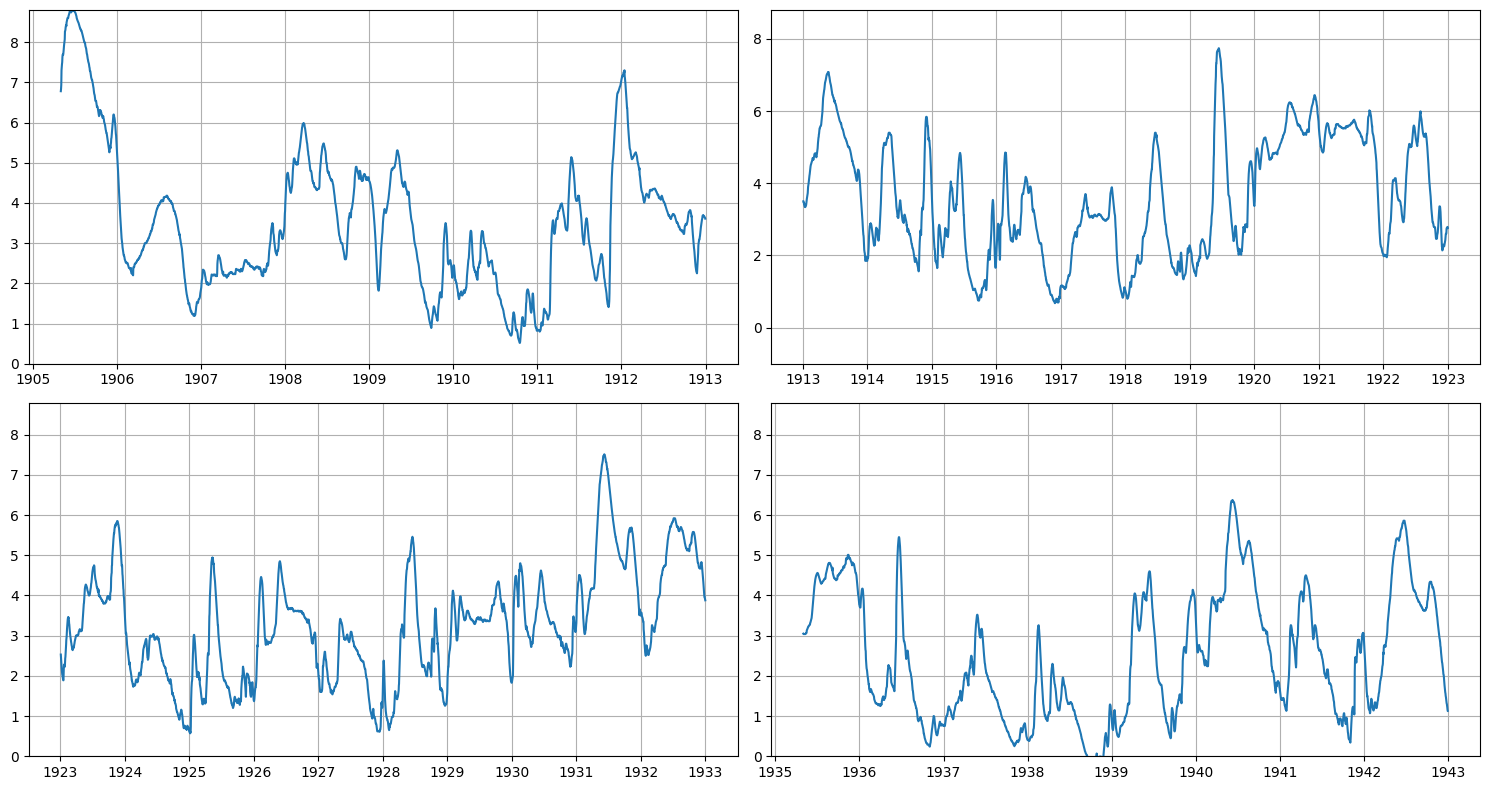

In [17]:
data1 = muestra14['nivel'][-2800:]
data2 = muestra13['nivel'][-3650:]
data3= muestra12['nivel'][-3650:]
data4= muestra11['nivel'][-2800:]
# Calcula el rango máximo y mínimo para todos los conjuntos de datos (excepto el límite inferior)
max_nivel = max(data1.max(), data2.max(), data3.max(),data4.max())
# Crea la figura y define la cuadrícula
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(nrows=2, ncols=2)
# Diagrama del primer gráfico en el subplot superior izquierdo
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(data1)
ax1.grid(True)

# Diagrama del segundo gráfico en el subplot superior derecho
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(data2)
ax2.grid(True)


ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(data3)
ax3.grid(True)

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(data4)
ax4.grid(True)

ax1.set_ylim(0, max_nivel)
ax2.set_ylim(-1, max_nivel)
ax3.set_ylim(0, max_nivel)
ax4.set_ylim(0, max_nivel)
# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()

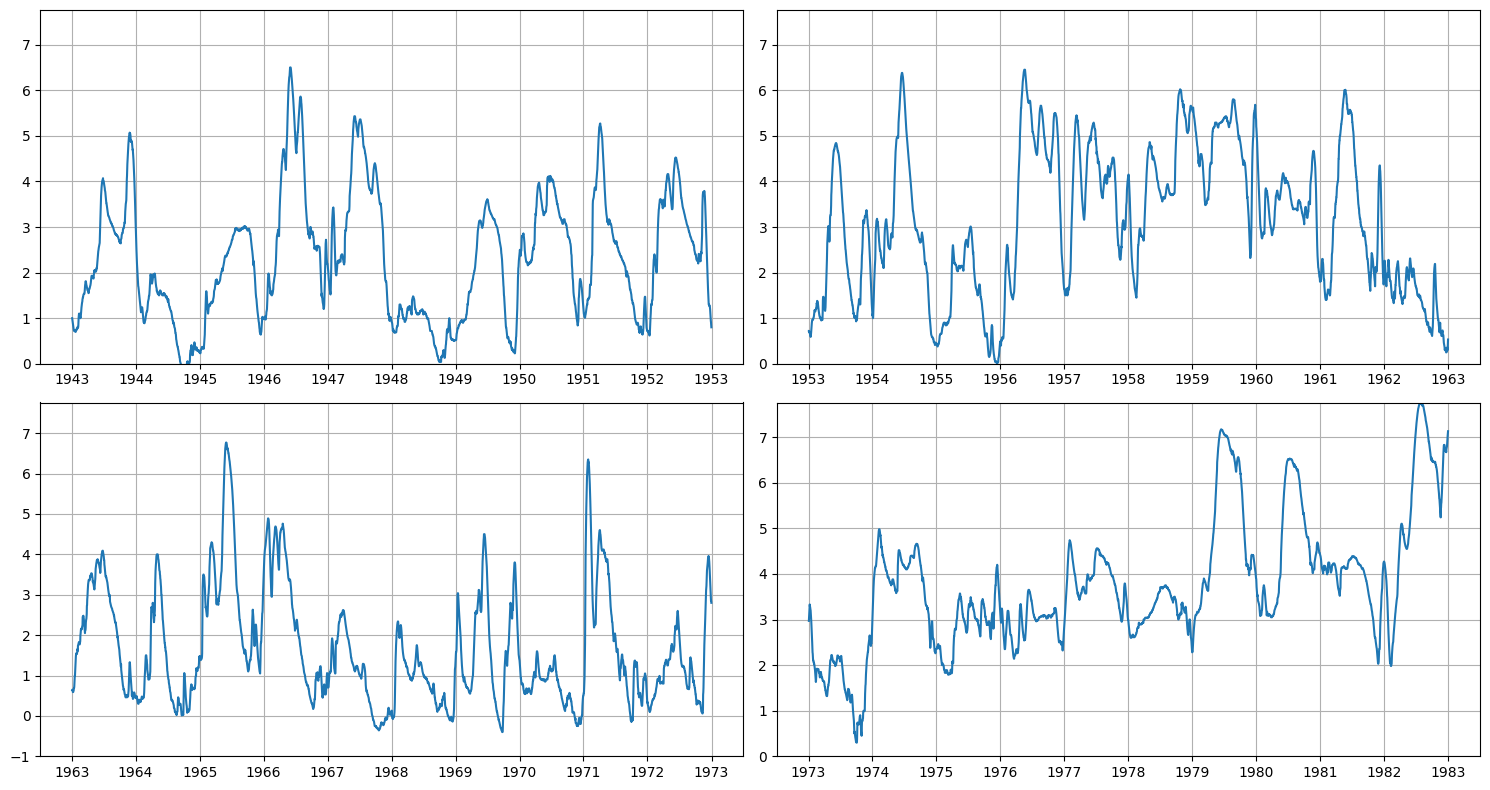

In [18]:
data1 = muestra10['nivel'][-3650:]
data2 = muestra9['nivel'][-3650:]
data3= muestra8['nivel'][-3650:]
data4= muestra7['nivel'][-3650:]
# Calcula el rango máximo y mínimo para todos los conjuntos de datos (excepto el límite inferior)
max_nivel = max(data1.max(), data2.max(), data3.max(),data4.max())
# Crea la figura y define la cuadrícula
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(nrows=2, ncols=2)
# Diagrama del primer gráfico en el subplot superior izquierdo
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(data1)
ax1.grid(True)

# Diagrama del segundo gráfico en el subplot superior derecho
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(data2)
ax2.grid(True)


ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(data3)
ax3.grid(True)

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(data4)
ax4.grid(True)

ax1.set_ylim(0, max_nivel)
ax2.set_ylim(0, max_nivel)
ax3.set_ylim(-1, max_nivel)
ax4.set_ylim(0, max_nivel)
# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()

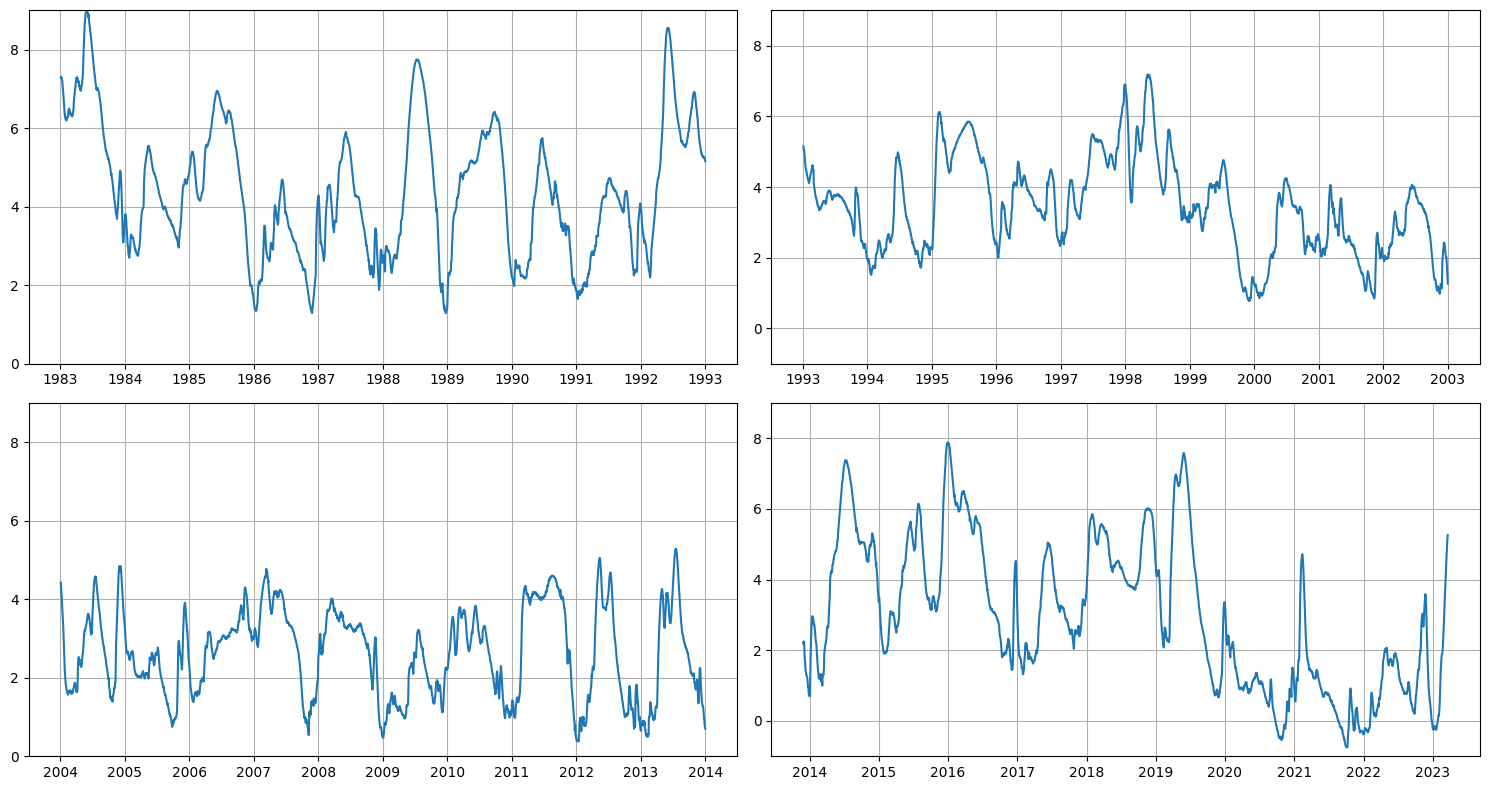

In [19]:
data1 = muestra1['nivel'][-3650:]
data2 = muestra2['nivel'][-3650:]
data3 = muestra3['nivel'][-3650:]
data4 = muestra4['nivel'][-3400:]

# Calcula el rango máximo y mínimo para todos los conjuntos de datos (excepto el límite inferior)
max_nivel = max(data1.max(), data2.max(), data3.max(), data4.max())

# Crea la figura y define la cuadrícula
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(nrows=2, ncols=2)

# Diagrama del primer gráfico en el subplot superior izquierdo
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(data1)
ax1.grid(True)

# Diagrama del segundo gráfico en el subplot superior derecho
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(data2)

ax2.grid(True)

# Diagrama del tercer gráfico en el subplot inferior derecho
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(data3)

ax3.grid(True)

# Diagrama del cuarto gráfico en el subplot inferior derecho
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(data4)

ax4.grid(True)

# Ajusta el rango del eje y para todos los subplots, estableciendo -1 como límite inferior
ax1.set_ylim(0, max_nivel)
ax2.set_ylim(-1, max_nivel)
ax3.set_ylim(0, max_nivel)
ax4.set_ylim(-1, max_nivel)

# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()


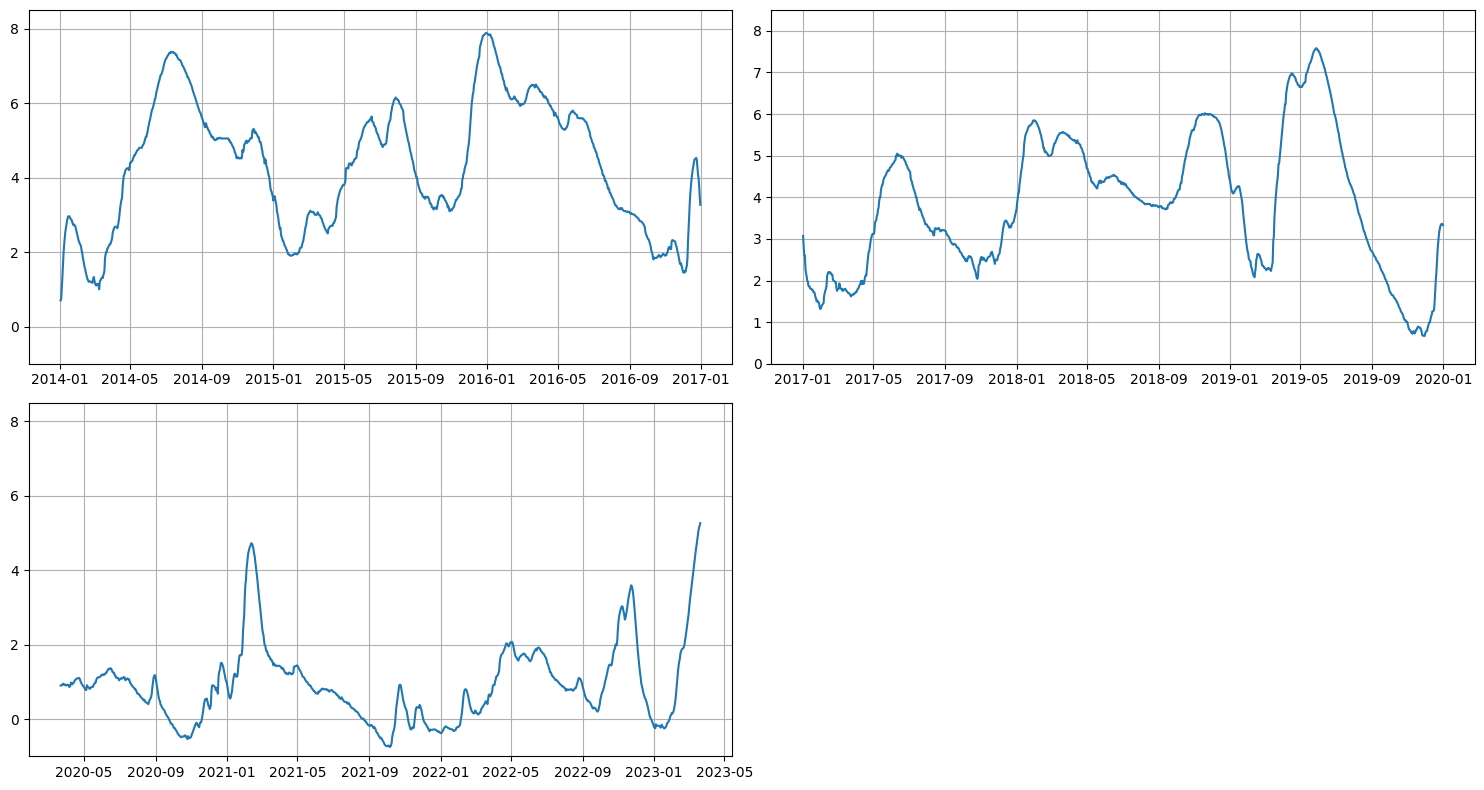

In [20]:

data4 = muestra4['nivel'][-1095:]
data5 = muestra5['nivel'][-1095:]
data6 = muestra6['nivel'][-1095:]
# Crea la figura y define la cuadrícula
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(nrows=2, ncols=2)

# Diagrama del primer gráfico en el subplot superior izquierdo
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(data4)
ax1.grid(True)

# Diagrama del segundo gráfico en el subplot superior derecho
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(data5)
ax2.grid(True)

ax3 = fig.add_subplot(gs[0, 0])
ax3.plot(data6)
ax3.grid(True)


# Ajusta el rango del eje y para todos los subplots, estableciendo -1 como límite inferior
ax1.set_ylim(-1, 8.5)
ax2.set_ylim(0, 8.5)
ax3.set_ylim(-1, 8.5)

# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()

In [ ]:
train['nivel'][-3650:].plot()

In [21]:
#test de KPSS o ADF (dickey fuller)
from statsmodels.tsa.stattools import adfuller
X=train['nivel'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.011606
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


El valor de esta estadística es -7.011647. Este valor es más negativo que los valores críticos en el nivel del 1%, 5% y 10%, lo que sugiere que podemos rechazar la hipótesis nula de que la serie tiene una raíz unitaria. En otras palabras, la serie es estacionaria.  
 rechazamos la hipótesis nula de no estacionariedad por p=0.  
Critical Values: Son los valores críticos para diferentes niveles de significancia (1%, 5% y 10%). Estos valores se utilizan para comparar con la estadística ADF. Como el valor de la estadística ADF es más negativo que los valores críticos, reforzando la idea de que la serie es estacionaria.


In [22]:
#definicion de la arquitectura RNN red neuronal recurrente con capa LSTM para capturar dependencias a largo plazo de una serie temporal
model=keras.Sequential()
model.add(tf.keras.layers.LSTM(cantidad_unidades, input_shape=(tamanio_ventana, nfeatures)))
#capa dropout (evita sobreajustes)
model.add(tf.keras.layers.Dropout(rate=dropout))
model.add(tf.keras.layers.Dense(horizonte))#genera predicciones del horizonte deseado

In [23]:
#funcion para ponderar , asigna pesos (mayor elementos iniciales)/(menor elementos posteriores)
def exponential_decay_weights(seq_length, decay_factor): #seq_legth dimension de la secuencia temporal , decay factor tasa de disminucion de peso
    weights = np.exp(-decay_factor * np.arange(seq_length))#cada elemento del vector  se calcula con el exp(-factor* ...)
    return weights / np.sum(weights) #retorna un vector weights de long seq_length np.sum suma el total de los pesos y normaliza para que el total sea 1


La función exponential_decay_weights es útil para aplicaciones de aprendizaje automático que involucran series temporales donde la información temprana puede ser más relevante.

In [24]:
# Esta función calcula el error cuadrático medio (MSE)
# ponderado a lo largo de la secuencia temporal, teniendo en cuenta la importancia decreciente de los elementos anteriores.
def multi_step_loss(y_true, y_pred): #tensores y_true , y_pred donde y_true (etiquetas) , y_pred valores predichos del modelo
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    seq_length = 28  # Length of the time series
    decay_factor = -0.05  # Controls the rate of decay
    weights = tf.constant(exponential_decay_weights(seq_length, decay_factor), dtype=tf.float32)#usamos la funcion anterior para los pesos
    squared_diff = tf.square(y_true - y_pred)#diferencia al cuadrado elemento a elemento entre (y_true - y_pred)
    weighted_squared_diff = tf.math.multiply(squared_diff, tf.expand_dims(weights, axis=-1))
    mse= tf.reduce_mean(weighted_squared_diff )#error cuadratico medio ponderado
    num_steps = 28  # Number of steps in each prediction
    adjusted_loss = mse / num_steps #ajuste de acuerdo al nro de pasos
    return adjusted_loss #error cuadratico medio

In [25]:
#configuracion del proceso de entrenamiento de la red neuronal
#model.compile(optimizer , loss , info adicional monitoreo del mse)
model.compile(optimizer=keras.optimizers.Adam(0.001), loss=multi_step_loss,metrics=[RootMeanSquaredError()])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60)                15360     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 28)                1708      
                                                                 
Total params: 17068 (66.67 KB)
Trainable params: 17068 (66.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
start_time = time.time() #sirve para calculo de tiempo de ejecucion
#callback de detencion temprana , monitoriza val_loss y si en 10 epochs no mejora la perdida de validacion se detiene
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# controla cuánto se actualizan los pesos del modelo en cada paso de entrenamiento.
# Un valor más alto permite un aprendizaje más rápido al principio,
#mientras que un valor más bajo permite un ajuste más fino en las etapas posteriores.
initial_learning_rate=0.0005
def lr_step_decay(epoch, lr): #ingresa epoca actual y lr actual
    drop = 0.5 #factor de decremento , baja el lr 0.5 con cada paso
    epochs_drop = 10#epocas que pasan entre cada decremento
    lr = initial_learning_rate * (drop ** (epoch // epochs_drop)) # se renueva el lr
    return lr
#Se crea un programador del ratio de aprendizaje para ajustar el ratio de aprendizaje durante el entrenamiento.
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)
epocas=200
callbacks_list = [early_stopping,lr_scheduler ]#lista (callback, programador )
#se inicia el entrenamiento
#history contiene información sobre el proceso de entrenamiento, como la pérdida de entrenamiento y validación en cada época.
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epocas, shuffle=False,batch_size=tamanio_batch, verbose=1, callbacks=[callbacks_list])
#se realiza la prediccion de x_val , las predicciones se escalan al valor original para luego ser comparadas o y_val
Y_prediction = valScaler.inverse_transform(np.hstack(((model.predict(x_val).reshape(-1, 1), np.zeros((np.size(y_val),nfeatures -1))))))[:, 0]

y_val_inv=valScaler.inverse_transform(np.hstack(((y_val.reshape(-1, 1), np.zeros((np.size(y_val),nfeatures -1))))))[:, 0]
#se calcula mse
mse=mean_squared_error( y_val_inv, Y_prediction)
#raiz cuadrado del mse
rmse=np.sqrt(mse)
#error maximo entre y_val_inv e y_prediction
maxError_=max_error(y_val_inv, Y_prediction)
#coeficiente de determinacion r cuadrado
#indica la proporción de la varianza en las etiquetas de validación
#que puede explicarse por el modelo. Un valor de R-cuadrado cercano a 1 indica un buen ajuste del modelo.
r2_=r2_score(y_val_inv, Y_prediction)
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  ))
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  ))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time step : {elapsed_time:.6f} seconds")

Epoch 1/200
250/250 [==============================] - 8s 34ms/step - loss: 4.7902e-06 - root_mean_squared_error: 0.0613 - val_loss: 1.2034e-05 - val_root_mean_squared_error: 0.0971 - lr: 5.0000e-04
Epoch 2/200
250/250 [==============================] - 5s 19ms/step - loss: 4.7272e-06 - root_mean_squared_error: 0.0609 - val_loss: 1.1936e-05 - val_root_mean_squared_error: 0.0967 - lr: 5.0000e-04
Epoch 3/200
250/250 [==============================] - 5s 19ms/step - loss: 4.5593e-06 - root_mean_squared_error: 0.0598 - val_loss: 1.1877e-05 - val_root_mean_squared_error: 0.0965 - lr: 5.0000e-04
Epoch 4/200
250/250 [==============================] - 5s 21ms/step - loss: 4.5179e-06 - root_mean_squared_error: 0.0595 - val_loss: 1.1760e-05 - val_root_mean_squared_error: 0.0960 - lr: 5.0000e-04
Epoch 5/200
250/250 [==============================] - 5s 20ms/step - loss: 4.4505e-06 - root_mean_squared_error: 0.0591 - val_loss: 1.1719e-05 - val_root_mean_squared_error: 0.0959 - lr: 5.0000e-04
Epoch

In [33]:
import seaborn as sns #libreria de matplotlib crea visualizaciones esteticas
from matplotlib.ticker import FormatStrFormatter#formatear las etiquetas de los ejes en los gráficos, permitiendo especificar un formato de cadena para los valores.
import matplotlib.dates as dates #Este módulo proporciona funciones y clases para trabajar con datos temporales en gráficos de matplotlib
from matplotlib import dates as mdates#se puede utilizar para acceder a funciones y clases relacionadas con fechas dentro de matplotlib

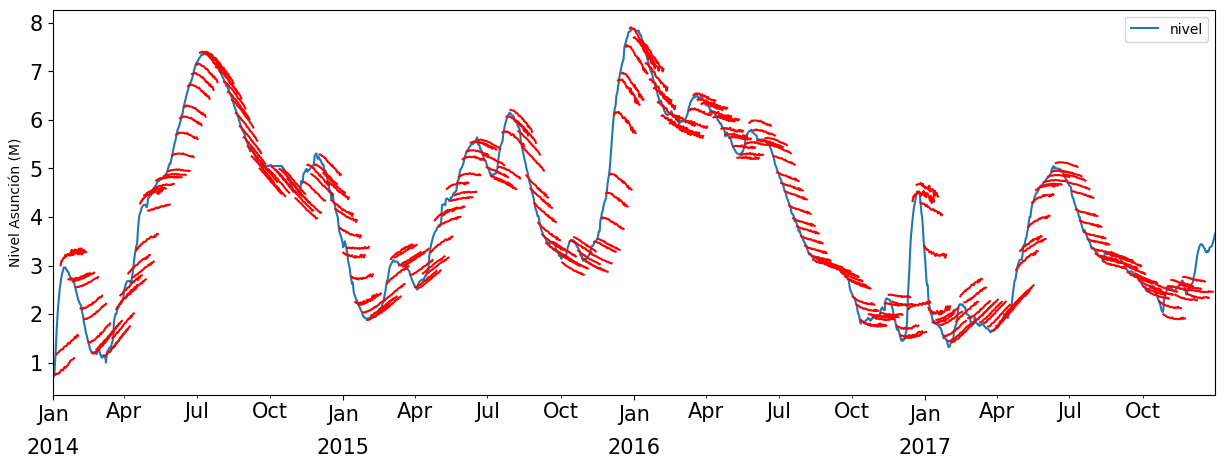

In [34]:
df=val[['nivel']][ tamanio_ventana:]
# se crea una figura f y el eje ax
f, ax = plt.subplots(figsize=(15,5))
#graficos de lineas con datos de df y eje ax
sns.lineplot(data =df,ax=ax)
#Formato de fechas
#objeto localizador coloca marcas menores cada 3 meses
fmt_month = mdates.MonthLocator(interval=3)
# Minor ticks every year.
#marcas cada anho
fmt_year = mdates.YearLocator()

ax.xaxis.set_minor_locator(fmt_month)
# '%b' to get the names of the month Muestra los meses como Ene, Feb ..
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# fontsize for month labels
ax.tick_params(labelsize=15, which='both') #tamanho de fuente de las etiquetas de marcas
    # create a second x-axis beneath the first x-axis to show the year in YYYY format
    #el eje se coloca por debajo al principal
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide the second x-axis spines and ticks
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)

ax.set_ylabel('Nivel Asunción (M)')
ax.set_xlabel('')

ax.set_xlim(df.index[0],df.index[-1])
j=0
mse=[]
maxe=[]
t=[]
    #El bucle itera sobre los valores predichos (Y_prediction) con un paso de horizonte.
for i in range(0, len(Y_prediction),horizonte):
  if(j%5==0 and (j+horizonte)<len(df)): #si j es divisible por 5 calcula mse , maxErr de
        #los valores reales de df.nivel[j:(j+horizonte)]) y valores predichos Y_prediction[i:i+horizonte]
    mse.append(mean_squared_error(np.array(df.nivel[j:(j+horizonte)]), Y_prediction[i:i+horizonte]))
    maxe.append(max_error(np.array(df.nivel[j:(j+horizonte)]), Y_prediction[i:i+horizonte]))
    t.append(df.index[j])

    plt.plot(df.index[j:(j+horizonte)], Y_prediction[i:i+horizonte], color='red')
  j=j+1

plt.show()

Las líneas rojas proporcionan una estimación de cómo el modelo espera que cambie el nivel del río en el futuro.  
La pendiente de las líneas rojas indica la tendencia pronosticada en el nivel del río (aumento, disminución o estabilidad).  
El modelo puede tener dificultades para predecir eventos extremos, como inundaciones repentinas o sequías severas.  
El modelo funciona para horizontes de prediccion cortos


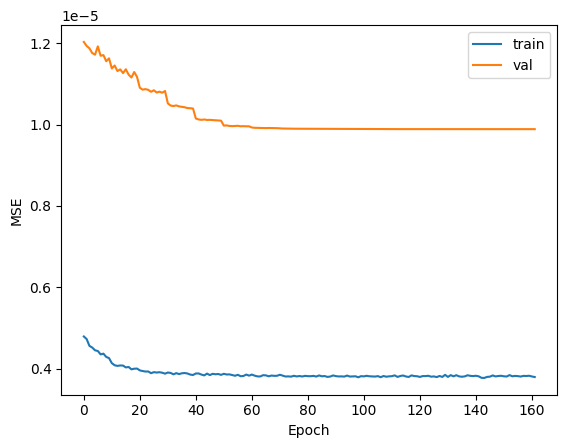

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

  El gráfico muestra que el MSE del modelo disminuye tanto en los datos de entrenamiento como en los datos de validación a medida que avanza el entrenamiento. Esto indica que el modelo está aprendiendo efectivamente a predecir el nivel del río.  
Se observa un posible problema de sobreajuste en las primeras épocas de entrenamiento.


# **Tomando el rango de temporalidad 2018 a 2022 para el test**   
con x_test , y_test

In [36]:
lista=[['nivel'],['nivel','week_cos','week_sin']]
seed=42
#semilla aleatoria para determinismo
tf.random.set_seed(seed)
np.random.seed(seed)
datos_normm=datos_norm[lista[features_set]]
nfeatures=len(datos_normm.columns)
#01-01-1973-545 dias = 22-12-1972 fecha inicial
desde=(dt.datetime.strptime('19'+str(year_ini)+'-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')
#subconjunto train  22-12-1972 a 31-12-2013
train = datos_normm.loc[desde:'2017-12-31']
#tomando los indices del subconjunto
ix=train.index
trainScaler = MinMaxScaler(feature_range=(0, 1))#del sklearn
trainScaler.fit(train)#se normaliza el subconjunto entre 0 a 1
#transform(train) es un array Numpy y se aplica la normalizacion
#se crea un nuevo dataframe llamado trainScaled
trainScaled = pd.DataFrame(trainScaler.transform(train),columns=train.columns)
trainScaled.set_index(ix)
#Preparar los datos de entrenamiento con la funcion
x_train, y_train=preparar_datos(tamanio_ventana,horizonte, trainScaled)

#para el subconjunto TEST se toma la fecha inicial 01-01-2018
desde=(dt.datetime.strptime('2018-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')
#Subconjunto validacion mismo proceso anterior  al subconjunto entrenamiento
test = datos_normm.loc[desde:'2022-12-31'] # 4 años para el conjunto test
ix=test.index
testScaler = MinMaxScaler(feature_range=(0, 1))
testScaler.fit(test)##??????????????
testScaled = pd.DataFrame(testScaler.transform(test),columns=test.columns)
testScaled.set_index(ix)
#preprarar datos conjunto validacion
x_test, y_test=preparar_datos(tamanio_ventana,horizonte, testScaled)

In [37]:
#definicion de la arquitectura RNN red neuronal recurrente con capa LSTM para capturar dependencias a largo plazo de una serie temporal
model=keras.Sequential()
model.add(tf.keras.layers.LSTM(cantidad_unidades, input_shape=(tamanio_ventana, nfeatures)))
#capa dropout (evita sobreajustes)
model.add(tf.keras.layers.Dropout(rate=dropout))
model.add(tf.keras.layers.Dense(horizonte))#genera predicciones del horizonte deseado
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mean_absolute_error',metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60)                15360     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 28)                1708      
                                                                 
Total params: 17068 (66.67 KB)
Trainable params: 17068 (66.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# controla cuánto se actualizan los pesos del modelo en cada paso de entrenamiento.
# Un valor más alto permite un aprendizaje más rápido al principio,
#mientras que un valor más bajo permite un ajuste más fino en las etapas posteriores.
initial_learning_rate=0.0005
def lr_step_decay(epoch, lr): #ingresa epoca actual y lr actual
    drop = 0.5 #factor de decremento , baja el lr 0.5 con cada paso
    epochs_drop = 10#epocas que pasan entre cada decremento
    lr = initial_learning_rate * (drop ** (epoch // epochs_drop)) # se renueva el lr
    return lr
#Se crea un programador del ratio de aprendizaje para ajustar el ratio de aprendizaje durante el entrenamiento.
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)
epocas=200
callbacks_list = [early_stopping,lr_scheduler ]#lista (callback, programador )
#se inicia el entrenamiento
#history contiene información sobre el proceso de entrenamiento, como la pérdida de entrenamiento y validación en cada época.
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epocas, shuffle=False,batch_size=tamanio_batch, verbose=1, callbacks=[callbacks_list])

Epoch 1/200
274/274 [==============================] - 8s 24ms/step - loss: 0.1420 - root_mean_squared_error: 0.1907 - val_loss: 0.0995 - val_root_mean_squared_error: 0.1348 - lr: 5.0000e-04
Epoch 2/200
274/274 [==============================] - 5s 19ms/step - loss: 0.0837 - root_mean_squared_error: 0.1100 - val_loss: 0.0824 - val_root_mean_squared_error: 0.1144 - lr: 5.0000e-04
Epoch 3/200
274/274 [==============================] - 6s 23ms/step - loss: 0.0706 - root_mean_squared_error: 0.0933 - val_loss: 0.0746 - val_root_mean_squared_error: 0.1046 - lr: 5.0000e-04
Epoch 4/200
274/274 [==============================] - 5s 19ms/step - loss: 0.0636 - root_mean_squared_error: 0.0846 - val_loss: 0.0693 - val_root_mean_squared_error: 0.0979 - lr: 5.0000e-04
Epoch 5/200
274/274 [==============================] - 6s 21ms/step - loss: 0.0591 - root_mean_squared_error: 0.0793 - val_loss: 0.0664 - val_root_mean_squared_error: 0.0949 - lr: 5.0000e-04
Epoch 6/200
274/274 [========================

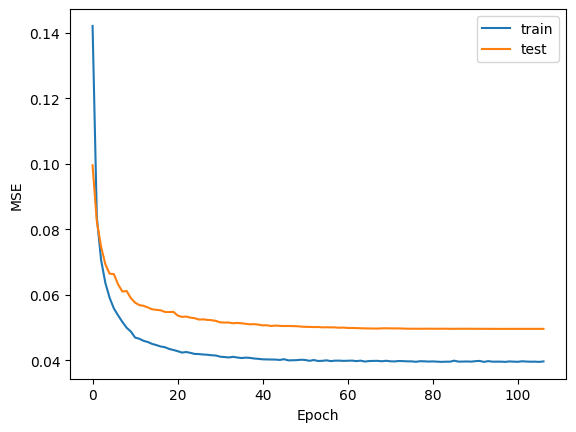

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])#??????
plt.title('')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper right')#????????
plt.show()



*   Las flucutaciones no son un problema puede deberse a que el modelo ajusta sus parámetros y explora el espacio de datos.
*   Las curvas convergen a un valor menor y se estabilizan con la época , lo que puede indicar que el modelo está acercandose a un nivel óptimo



In [40]:
Y_prediction = testScaler.inverse_transform(np.hstack(((model.predict(x_test).reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0]

y_test_inv=testScaler.inverse_transform(np.hstack(((y_test.reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0]
#se calcula mse
mse=mean_squared_error( y_test_inv, Y_prediction)
#raiz cuadrado del mse
rmse=np.sqrt(mse)#error promedio
#error maximo entre y_val_inv e y_prediction
maxError_=max_error(y_test_inv, Y_prediction)
#coeficiente de determinacion r cuadrado
#indica la proporción de la varianza en las etiquetas de validación
#que puede explicarse por el modelo. Un valor de R-cuadrado cercano a 1 indica un buen ajuste del modelo.
r2_=r2_score(y_test_inv, Y_prediction)
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  ))
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  ))

57/57 [==============================] - 1s 15ms/step
MSE: 0.42526273486850724 RMSE:0.6521217178322672
MaxError: 4.286462474763392 R2:0.9033864804418916


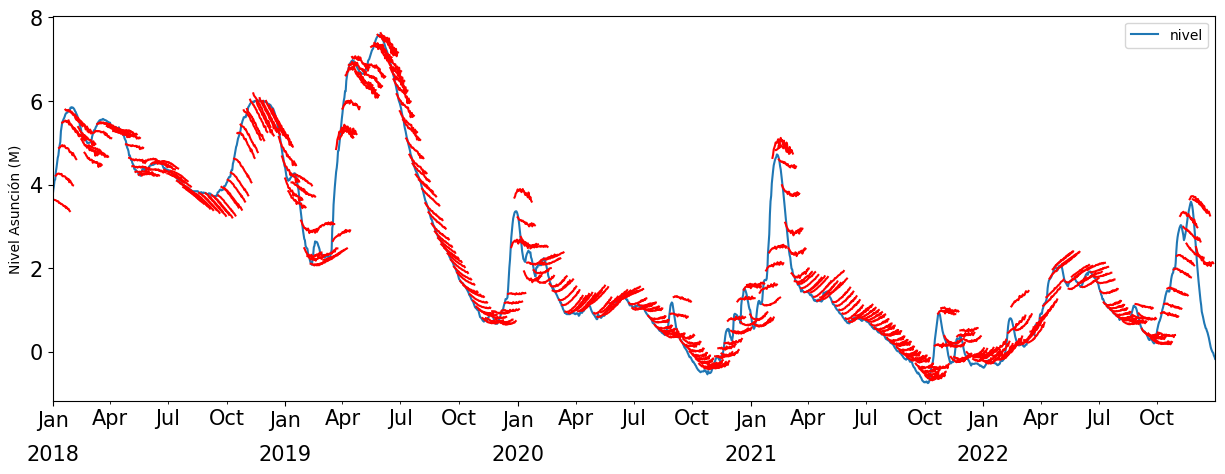

In [41]:
df=test[['nivel']][ tamanio_ventana:]
# se crea una figura f y el eje ax
f, ax = plt.subplots(figsize=(15,5))
#graficos de lineas con datos de df y eje ax
sns.lineplot(data =df,ax=ax)
#Formato de fechas
#objeto localizador coloca marcas menores cada 3 meses
fmt_month = mdates.MonthLocator(interval=3)
# Minor ticks every year.
#marcas cada anho
fmt_year = mdates.YearLocator()

ax.xaxis.set_minor_locator(fmt_month)
# '%b' to get the names of the month Muestra los meses como Ene, Feb ..
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# fontsize for month labels
ax.tick_params(labelsize=15, which='both') #tamanho de fuente de las etiquetas de marcas
    # create a second x-axis beneath the first x-axis to show the year in YYYY format
    #el eje se coloca por debajo al principal
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide the second x-axis spines and ticks
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)

ax.set_ylabel('Nivel Asunción (M)')
ax.set_xlabel('')

ax.set_xlim(df.index[0],df.index[-1])
j=0
mse=[]
maxe=[]
t=[]
    #El bucle itera sobre los valores predichos (Y_prediction) con un paso de horizonte.
for i in range(0, len(Y_prediction),horizonte):
  if(j%5==0 and (j+horizonte)<len(df)): #si j es divisible por 5 calcula mse , maxErr de
        #los valores reales de df.nivel[j:(j+horizonte)]) y valores predichos Y_prediction[i:i+horizonte]
    mse.append(mean_squared_error(np.array(df.nivel[j:(j+horizonte)]), Y_prediction[i:i+horizonte]))
    maxe.append(max_error(np.array(df.nivel[j:(j+horizonte)]), Y_prediction[i:i+horizonte]))
    t.append(df.index[j])

    plt.plot(df.index[j:(j+horizonte)], Y_prediction[i:i+horizonte], color='red')
  j=j+1

plt.show()